1. The PA of Sersic won't agree with PA of non-par measurement
2. The Sersic center will be far from true center
2. M20 will be super large -> easy to rule out things

In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet
from scarlet.display import AsinhMapping
from scarlet.source import StarletSource

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row
from astropy.convolution import convolve, Gaussian2DKernel

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [19]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat.fits')
#lsbg = lsbg_cat[np.where(lsbg_cat['viz-id'] == 32625)[0]][0]

In [20]:
length = len(lsbg_cat)
bands = 4

meas_cat = Table([
    Column(name='ID', length=length, dtype=int),
    Column(name='flux', length=length, shape=(bands,)),
    Column(name='mag', length=length, shape=(bands,)),
    Column(name='SB_0', length=length, shape=(bands,)),
    Column(name='SB_eff_circ', length=length, shape=(bands,)),
    Column(name='SB_eff_ellip', length=length, shape=(bands,)),
    Column(name='xc_cen', length=length),
    Column(name='yc_cen', length=length),
    Column(name='xc_sym', length=length),
    Column(name='yc_sym', length=length),
    Column(name='ell_cen', length=length),
    Column(name='ell_sym', length=length),
    Column(name='PA_cen', length=length),
    Column(name='PA_sym', length=length),
    Column(name='rhalf_circ', length=length),
    Column(name='rhalf_ellip', length=length),
    Column(name='r20', length=length),
    Column(name='r50', length=length),
    Column(name='r80', length=length),
    Column(name='Gini', length=length),
    Column(name='M20', length=length),
    Column(name='F(G,M20)', length=length),
    Column(name='S(G,M20)', length=length),
    Column(name='C', length=length),
    Column(name='A', length=length),
    Column(name='S', length=length),
    Column(name='sersic_n', length=length),
    Column(name='sersic_rhalf', length=length),
    Column(name='sersic_ell', length=length),
    Column(name='sersic_PA', length=length),
    Column(name='sersic_xc', length=length),
    Column(name='sersic_yc', length=length),
    Column(name='sersic_amp', length=length),
    Column(name='flag', length=length, dtype=bool),
    Column(name='flag_sersic', length=length, dtype=bool),
])
for col in meas_cat.columns:
    meas_cat[col] = np.nan * meas_cat[col]

In [21]:
from kuaizi.measure import _write_to_row

In [23]:
for i, lsbg in enumerate(lsbg_cat):
    row = meas_cat[i]
    row['ID'] = lsbg['viz-id']
    
    try:
        with open(f"./Model/NSA/nsa-{lsbg['viz-id']}-trained-model-wavelet.df", "rb") as fp:
            blend, info, mask = dill.load(fp)
            fp.close()
    except Exception as e:
        print(i, e)
    
    # Measure!
    try:
        measurement, morph = kz.measure.makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                                        blend.observations[0], 
                                                        aggr_mask=mask.astype(bool), 
                                                        sigma=0.5,
                                                        zeropoint=27.0, out_prefix=None, 
                                                        show_fig=False, asinh_a=0.02, framealpha=0.7)
        row = _write_to_row(row, measurement)
#         with open(f"./Measure/NSA/nsa-{lsbg['viz-id']}-wavelet.df", "wb") as fp:
#             dill.dump([measurement, morph], fp)
#             fp.close()
    except Exception as e:
        print(i, e)
        
    if i % 5 == 0:
        print(f'Progress: {i}')

Progress: 0
1 The segmentation image must contain at least one non-zero pixel.
Progress: 5
7 The segmentation image must contain at least one non-zero pixel.
Progress: 10
Progress: 15
Progress: 20
Progress: 25
Progress: 30
Progress: 35
Progress: 40
41 The segmentation image must contain at least one non-zero pixel.
Progress: 45
48 The segmentation image must contain at least one non-zero pixel.
Progress: 50
53 [Errno 2] No such file or directory: './Model/NSA/nsa-23076-trained-model-wavelet.df'
Progress: 55
Progress: 60
Progress: 65
Progress: 70
Progress: 75
Progress: 80
Progress: 85
Progress: 90
91 [Errno 2] No such file or directory: './Model/NSA/nsa-36129-trained-model-wavelet.df'
92 The segmentation image must contain at least one non-zero pixel.
95 [Errno 2] No such file or directory: './Model/NSA/nsa-36974-trained-model-wavelet.df'
Progress: 95
Progress: 100
Progress: 105
Progress: 110
Progress: 115
Progress: 120
Progress: 125
Progress: 130
Progress: 135
Progress: 140
145 The seg

In [26]:
meas_cat.write('./Catalog/nsa_test_sample_measurement_1011.fits', overwrite=True)

### Analysis

In [27]:
import kuaizi
kuaizi.set_matplotlib(style='nature', usetex=False)

In [91]:
meas_cat = Table.read('./Catalog/nsa_test_sample_measurement_1011.fits')

In [92]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['is_candy'] > 0)

In [93]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [94]:
mask = (g_mag - i_mag < 1.4) & (g_mag - i_mag > -0.1) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - 0.4) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + 0.4)
print('Candy:', np.sum(mask & candy))
print('Non-Junk:', np.sum(mask & ~junk))
print('Junk:', np.sum(mask & junk))

Candy: 86
Non-Junk: 178
Junk: 63


In [95]:
mask = mask & (meas_cat['rhalf_ellip'] * 0.168 > 2.5)
print('Candy:', np.sum(mask & candy))
print('Non-Junk:', np.sum(mask & ~junk))
print('Junk:', np.sum(mask & junk))

Candy: 52
Non-Junk: 95
Junk: 12


In [96]:
mask = mask & (meas_cat['SB_eff_circ'][:, 0] < 28.8) & (meas_cat['SB_eff_circ'][:, 0] > 24.3)
print('Candy:', np.sum(mask & candy))
print('Non-Junk:', np.sum(mask & ~junk))
print('Junk:', np.sum(mask & junk))

Candy: 35
Non-Junk: 53
Junk: 8


In [97]:
mask = mask & (meas_cat['sersic_ell'] < 0.7)
print('Candy:', np.sum(mask & candy))
print('Non-Junk:', np.sum(mask & ~junk))
print('Junk:', np.sum(mask & junk))

Candy: 34
Non-Junk: 47
Junk: 8


In [98]:
lsbg_cat[junk & mask]

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,cutout_size,prefix,radius,image_flag [5],psf_flag [5]
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcmin,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,bytes57,float64,bool,bool
224.966937,1.8929899,15.007,5.873,-27.82,0.609,21.5342,20.8924,20.4087,2.634492,3.668616,24.862306487358293,24.560616542934998,1.677481483062888,0.8830389907363476,0.4912357504841326,0.14093494552527447,0.0998706960094042,0.07127393626162194,9863,"2,2",-1,11566,0,1,0,1,0,1,3,1,2,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_11566,1.0,True .. True,True .. True
180.6376876,1.9556516,8.168,3.346,-9.08,0.59,22.3466,21.812,22.1102,5.283600000000001,4.627896,27.46908801928145,27.160553199600464,1.6834686511415247,0.34516525926349106,0.5717412229200318,0.06197879649632502,0.043920019416356516,0.03134405575981794,9833,"1,2",-1,26991,0,0,1,1,0,0,2,0,2,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_26991,1.0,True .. True,True .. True
18.896279,-0.8770328,18.092,5.284,-85.33,0.708,21.3245,20.9574,20.9168,8.902656,8.061648,27.574840359551683,26.866762208403724,1.358882537843368,0.6182936225835629,0.311410258118722,0.11047710775178197,0.07828736587050185,0.05587073033534288,9239,"6,3",-1,35955,0,0,0,2,0,0,2,0,2,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_35955,1.0,True .. True,True .. True
219.7855006,-0.539554,58.753,27.395,35.19,0.534,19.1782,17.7173,17.3494,13.875456,21.651756,26.269057018363032,25.711264761380917,1.1447668101414372,1.2349172937748043,0.8587305949536091,0.10011113218151585,0.07094172713512305,0.050628425956318716,9374,"1,5",-1,41706,0,0,0,2,0,0,2,0,2,1.5,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_41706,1.5,True .. True,True .. True
180.4870641,1.9991626,18.904,5.765,41.64,0.695,20.0071,19.8496,19.6379,3.8051160000000004,3.7593360000000002,24.300855421508547,23.972718887465167,1.5273904294540943,0.3535694076349918,0.14206256695379296,0.06945607328915283,0.049218640242947455,0.03512548092414627,9833,"1,3",-1,53295,0,0,0,2,0,0,2,0,2,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_53295,1.0,True .. True,True .. True
18.7431921,0.1476383,18.825,11.255,31.66,0.402,21.4038,20.6287,20.5287,4.317516,4.251912000000001,25.979308806958578,24.97888154962268,1.5046326658938498,0.8575399706932997,0.6243913969919188,0.08994948357231157,0.06374088056423316,0.0454894542656138,9482,"7,1",-1,72054,0,0,0,1,0,1,2,0,2,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_72054,1.0,True .. True,True .. True
232.5114423,43.0431652,42.078,19.908,2.51,0.527,19.7137,17.4179,16.9624,8.384124,15.430884000000002,25.796383114693555,24.800807463655858,1.0954820441142286,1.3089242364046418,0.9406947626365272,0.0885651087007509,0.06275987133727816,0.04478934510539057,16003,"1,0",-1,84000,0,0,0,2,0,0,2,0,2,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_84000,1.0,True .. True,True .. True
148.2449419,0.5005327,27.41,19.675,-67.13,0.282,20.3829,17.8542,17.6969,6.319068000000001,12.258372000000001,25.768303097014016,25.053331618791713,1.175330563018992,0.6666388822401992,0.4467286777661236,0.08570306240139844,0.060731740167523605,0.04334194464159804,9569,"4,3",-1,87328,0,0,1,0,0,0,1,0,1,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_87328,1.0,True .. True,True .. True


In [100]:
meas_cat[~junk & mask]

ID,flux [4],mag [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1554.0,561.3335571289062 .. 1332.24169921875,20.1269474029541 .. 19.188541412353516,22.879039764404297 .. 21.94063377380371,24.67633819580078 .. 23.737934112548828,24.57107162475586 .. 23.632667541503906,65.01159887230408,64.86872735611469,65.14755836598158,64.70808826996787,0.46882962603963463,0.46868257511669376,0.48231384368311003,0.4822644496420969,11.8087100631838,15.97828597921468,5.775841092720232,11.786656060897432,24.798123717611293,0.5596390138974592,-1.8667826563039454,0.10389349961105676,-0.03244016546776385,3.1640179306084786,0.19192617037737125,0.043627796733815165,0.9589055613792082,15.86288855143544,0.4394054097141176,0.6239071617787099,65.02441164756931,64.66397458255162,0.2851441652621916,0.0,0.0
1601.0,698.3899536132812 .. 1285.361083984375,19.889755249023438 .. 19.227436065673828,22.645170211791992 .. 21.982852935791016,24.401702880859375 .. 23.7393856048584,24.386638641357422 .. 23.724321365356445,49.49098776287489,59.877040216254585,53.25000000280777,58.32419681101908,0.34488924917184915,0.34610301871734916,-0.9836841494373849,-0.9261067616953411,14.696909989118433,17.199127663696274,7.438390559402969,14.636454648122173,23.136734315801434,0.486617721292624,-1.2765378815018744,-0.666601527720712,-0.022687221449062822,2.464115409332079,0.5055745436901036,0.024768942722089876,1.261944715548494,25.294217763521775,0.5751449412352942,2.114697892328172,54.370895731159756,56.90158961861141,0.225625262216246,0.0,0.0
2141.0,367.281494140625 .. 652.098388671875,20.587501525878906 .. 19.964218139648438,22.7000675201416 .. 22.0767822265625,25.321504592895508 .. 24.698219299316406,25.292978286743164 .. 24.669692993164062,55.12569756266789,55.6749904169527,55.34920255259392,55.249999981499855,0.35839427766085097,0.3582699017713259,-0.4037497239348308,-0.40463616116570755,12.160142165208484,14.980884233112345,4.639672932678313,12.160142165508523,23.966177423200236,0.5419923347192416,-2.0871960730209507,0.169288935463765,-0.08054784277786303,3.565557017291649,0.21177208229478406,0.03640919159138217,1.3916398767352,13.810124551035328,0.49710569368054,2.289055675062659,55.304417326331695,55.34635375785659,0.22098927302432636,0.0,0.0
5812.0,97.49437713623047 .. 211.21998596191406,22.027551651000977 .. 21.18816375732422,26.61853790283203 .. 25.77914810180664,27.029653549194336 .. 26.190265655517578,26.99602699279785 .. 26.156639099121094,42.063487176356205,39.66787072547537,41.91376375614841,40.06660908130331,0.28742018046643447,0.2875242061520603,-0.6742728689323564,-0.6754388169089303,13.617448862639463,15.95806964784143,8.178030809254322,13.617448988504675,18.573863662959823,0.19177571841273822,-1.3627969475108908,-2.0662919092318983,-0.32657081447540304,1.7812675552032753,0.07870689559845574,0.04420840735858669,0.4781102075171095,25.256015441340868,0.42164044091278097,2.474879704206259,41.44323760886457,40.3518642276008,0.02046962881928958,0.0,0.0
11962.0,550.5150146484375 .. 1561.1131591796875,20.1480770111084 .. 19.016414642333984,22.410438537597656 .. 21.27877426147461,26.173383712768555 .. 25.04172134399414,26.15757942199707 .. 25.025917053222656,99.6151403085074,99.9084600268779,99.8097078292272,100.09846226140758,0.26113006055985666,0.2610266177300473,-0.5603543001659884,-0.560270308352336,20.661167575384795,24.144260076558528,9.353507906091728,20.661167575858098,35.47209722434403,0.45286455708535306,-2.087922664378033,-0.2713900360135253,-0.16888533883404705,2.89

Text(0, 0.5, 'g-r')

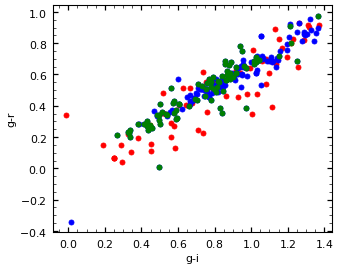

In [32]:
plt.scatter((g_mag - i_mag)[candy & mask], (g_mag - r_mag)[candy & mask], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk & mask], (g_mag - r_mag)[junk & mask], color='r')
plt.scatter((g_mag - i_mag)[~junk & mask], (g_mag - r_mag)[~junk & mask], color='b')

plt.xlabel('g-i')
plt.ylabel('g-r')

(-0.5, 2.0)

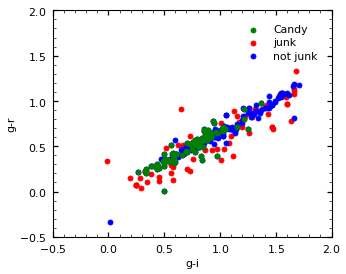

In [105]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[~junk], (g_mag - r_mag)[~junk], color='b', label='not junk')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

plt.xlim(-0.5, 2)
plt.ylim(-0.5, 2)

Text(0, 0.5, 'SB_0_i')

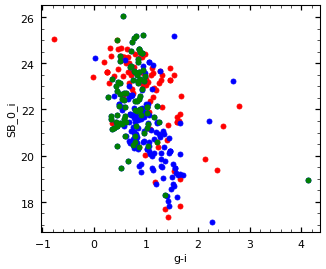

In [103]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_0'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_0'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[~junk], meas_cat['SB_0'][:, 2][~junk], color='b')

plt.xlabel('g-i')
plt.ylabel('SB_0_i')

Text(0, 0.5, 'SB_eff_i')

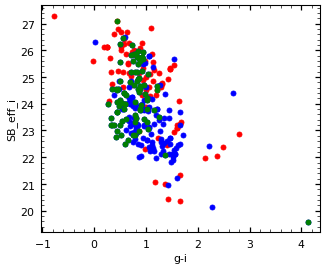

In [35]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_eff_circ'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_eff_circ'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[~junk], meas_cat['SB_eff_circ'][:, 2][~junk], color='b')

plt.xlabel('g-i')
plt.ylabel('SB_eff_i')

Text(0, 0.5, 'Gini')

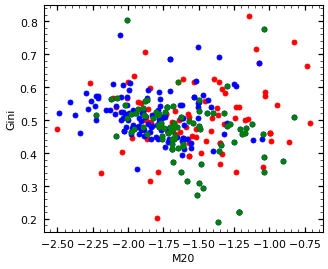

In [46]:
plt.scatter(meas_cat['M20'][candy], meas_cat['Gini'][candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk], meas_cat['Gini'][junk], color='r')
plt.scatter(meas_cat['M20'][~junk], meas_cat['Gini'][~junk], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

Text(0, 0.5, 'A')

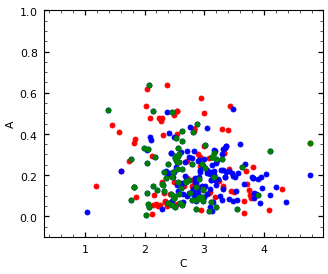

In [48]:
plt.scatter(meas_cat['C'][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['C'][~junk], meas_cat['A'][~junk], color='b')

plt.ylim(-0.1, 1)
plt.xlabel('C')
plt.ylabel('A')

Text(0, 0.5, 'S')

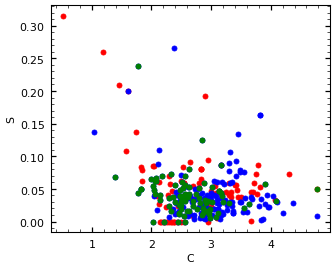

In [49]:
plt.scatter(meas_cat['C'][candy], meas_cat['S'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['S'][junk], color='r')
plt.scatter(meas_cat['C'][~junk], meas_cat['S'][~junk], color='b')

#plt.ylim(-0.1, 1)
plt.xlabel('C')
plt.ylabel('S')

Text(0, 0.5, 'r50')

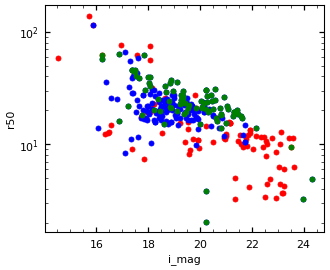

In [51]:
plt.scatter(i_mag[candy], meas_cat['r80'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['r80'][junk], color='r')
plt.scatter(i_mag[~junk], meas_cat['r80'][~junk], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

(0.0, 20.0)

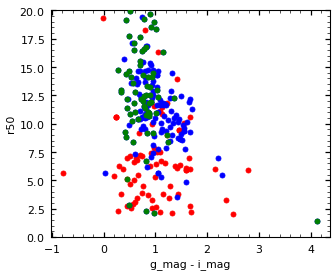

In [110]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['r50'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['r50'][junk], color='r')
plt.scatter((g_mag - i_mag)[~junk], meas_cat['r50'][~junk], color='b')

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 20)

In [107]:
12 * 0.168

2.016

Text(0, 0.5, 'r50')

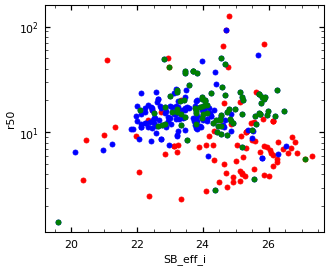

In [56]:
plt.scatter(meas_cat['SB_eff_circ'][:, 2][candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_circ'][:, 2][junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['SB_eff_circ'][:, 2][~junk], meas_cat['rhalf_ellip'][~junk], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

Text(0, 0.5, 'r50')

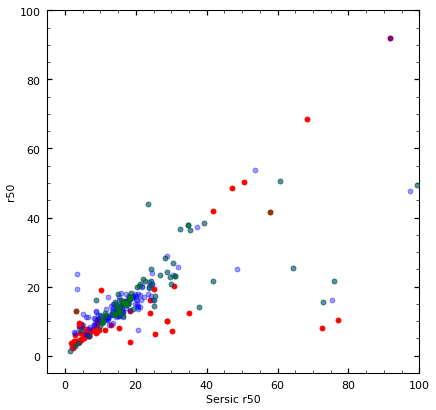

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['sersic_rhalf'][candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10, alpha=.4)
plt.scatter(meas_cat['sersic_rhalf'][junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['sersic_rhalf'][~junk], meas_cat['rhalf_ellip'][~junk], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
plt.xlim(-5, 100)
plt.ylim(-5, 100)

plt.xlabel('Sersic r50')
plt.ylabel('r50')

In [45]:
### Surface brightness

In [58]:
import photutils

In [90]:
image = morph._cutout_stamp_maskzeroed
r = morph.rhalf_circ
r_in = r - 0.5 * morph._annulus_width
r_out = r + 0.5 * morph._annulus_width

center = morph._asymmetry_center

circ_annulus = photutils.CircularAnnulus(center, r_in, r_out)

In [91]:
circ_annulus

<CircularAnnulus([171.849924  , 170.35016515], r_in=54.434000639315535, r_out=55.434000639315535)>

In [97]:
circ_annulus.do_photometry(image, method='exact')[0][0] / _aperture_area(circ_annulus, morph._mask_stamp)

0.10588904779862689

In [83]:
from statmorph.statmorph import _aperture_area

In [111]:
morph.SB_eff_ellip

0.1326720991633661

In [101]:
morph.SB_circ(30)

0.2309987992763701

In [102]:
morph.SB_circ(54)

0.1088485801924251

In [ ]:
## Central SB

In [169]:
image = morph._cutout_stamp_maskzeroed
center = morph._peak


In [176]:
SB_set = []
r_set = np.logspace(-1, 1, 25)
for r in r_set: 
    #r = 1 #morph.rhalf_circ
    circ_aper = photutils.CircularAperture(center, r)
    SB_set.append(circ_aper.do_photometry(image)[0][0] / circ_aper.area)

In [184]:
morph.SB_circ(1)

1.455276766395422

In [187]:
morph.SB_0_circ

array(2.31020329)

In [186]:
morph.SB_0_ellip

array(2.31018508)

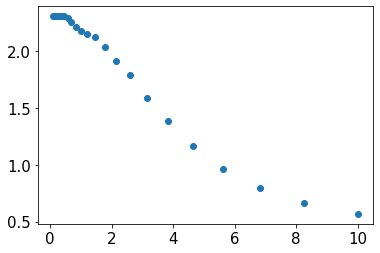

In [172]:
plt.scatter(np.logspace(-1, 1, 25), SB_set)

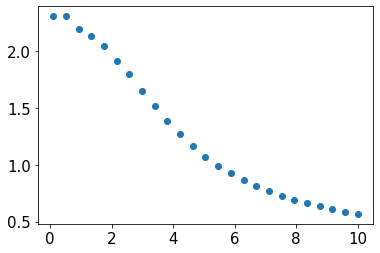

In [174]:
plt.scatter(np.linspace(0.1, 10, 25), SB_set)

In [191]:
from kuaizi import old_measure

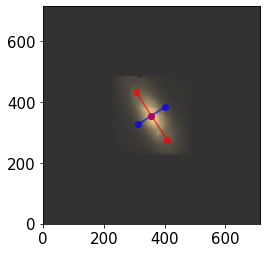

In [193]:
temp = old_measure.makeMeasurement(blend.sources[:1], observation, show_fig=True)

In [194]:
temp

{'x_cen': 356.64375168299165,
 'y_cen': 354.828377799406,
 'ra_cen': 192.23917417411988,
 'dec_cen': -0.7823414415960165,
 'x_cen_winpos': 357.55937458888684,
 'y_cen_winpos': 353.7215505902157,
 'ra_cen_winpos': 192.23913144106703,
 'dec_cen_winpos': -0.7823930935323838,
 'flux': array([1842.1173, 3056.3464, 3860.015 , 4216.0483], dtype=float32),
 'mag': array([18.836708, 18.286995, 18.033527, 17.937737], dtype=float32),
 'R50': array([11.73221851, 11.73221914, 11.73221971, 11.7322193 ]),
 'q': array([0.55651472, 0.55651472, 0.55651472, 0.55651472]),
 'pa': array([-56.94883183, -56.94883183, -56.94883184, -56.94883183]),
 'SB0': array([23.972975, 23.423262, 23.169796, 23.074005], dtype=float32),
 'SB0_winpos': array([24.399937, 23.850224, 23.596756, 23.500965], dtype=float32)}

In [197]:
-2.5 * np.log10(morph.SB_0_ellip / (0.168**2)) + 27.0

22.217429472498406

In [196]:
morph.SB_0_circ

array(2.31020329)